In [7]:

# coding: utf-8

# In[201]:


import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random


# In[202]:


def choose_hyperplane(d):
    sig = 1/np.sqrt(d)
    return np.random.normal(0, sig, size=(d))



def perceptron(X,t,max_iter=100, eta=0):
    N = len(X)
    d = len(X[0])
    N_chances = 1
    cand = []
    flag=0
    tX = []
    for i in range(N):
        tX.append(t[i]*X[i])
    W = choose_hyperplane(d)
    best = W
    best_acc = 0
    for n in range(N_chances):
        W = choose_hyperplane(d)
        W = W/np.linalg.norm(W)
        for k in range(max_iter):
            err = [int(np.dot(W,x)>=0) for x in tX]
    #        print(k, ' ', sum(err)*100.0/len(err))
            acc=(sum(err)*100.0/len(err))
    #         print(acc)
            if(acc>99.5*(1-eta)):
                print('Pretty Good!!')
                return W/np.linalg.norm(W)
            if(acc > best_acc):
                best_acc = acc
                best = W
            for i in range(N):
                err[i] = int(np.dot(W,tX[i])>=0)
                if(err[i]>0):
                    #correctly classified
                    prob = eta/(1-eta)
                    if(np.random.uniform(0,1)<prob):
                        W = W + tX[i]
                else:
                    W = W + tX[i]

            
    W = best
    print("Best accuracy is " + str(best_acc))
    return W/np.linalg.norm(W)



def f(W,x):
    if(np.dot(W,x)>=0):
        return 1
    else:
        return -1
    
    
def create_y_val(x):
    return 2/(1+np.exp(-x))
    
def pred(W,X):
    return [f(W,x) for x in X]


# In[203]:


e = np.exp(1)
def pdf(x):
#     e = np.exp(1)
    return x*np.exp(-x) * e / (e-2)

def create_distribution():
    arr = [0.001 * x for x in range(1000)]
    pd_arr = list(map(pdf, arr))
    dis = pd_arr/sum(pd_arr) 
    return np.array(arr), np.array(dis)


def create_along_W(W):
    beta = np.random.uniform(-1,1)
    noise = np.random.normal(0,1/np.sqrt(d),size=(d))
    return beta*np.reshape(W, (d)) + noise 




def create_ds(W, d, N):
    ds=[]
    Y = []
    Z = []
    sig = 1/np.sqrt(d)
    alpha = 0.66
    for i in range(N):
        x1 = np.random.normal(0,sig,size=(d))
        x2 = create_along_W(W)
        if(np.random.uniform(0,1)<alpha):
            x=x1
        else:
            x=x2
        val = np.dot(W,x)
        if(val>=0):
            z=1
        else:
            z=-1
        
        y=create_y_val(val)
        ds.append(x)
        Z.append(z)
        Y.append(y)
        
    return np.array(ds), np.array(Z), np.array(Y)




    

def corruption_mask(Z, Y, eta):
    arr, dis = create_distribution()
    nZ = []
    nY = []
    if(len(Z)!=len(Y)):
        print('ErrorZneqY')
    for ss in range(len(Z)):
        y = Y[ss]
        z = Z[ss]
        if(np.random.uniform(0,1)<eta):
            if(z==1):
                y=np.random.choice(arr, 1, p=dis)[0]
                nZ.append(-1)
            else:
                y=np.random.uniform(1,2)
                nZ.append(1)
            nY.append(y)
        else:
            nZ.append(z)
            nY.append(y)
    
    return np.array(nZ), np.array(nY)


def create_y(W, X, Z, method=1):
    Y = []
    N = len(Z)
    for i in range(N):
        if(method==1):
            if(Z[i]==1):
                y  = np.random.uniform(1,2)
            else:
                y = np.random.uniform(0,1)
        else:
            y = f(np.dot(W,X[i]))
        Y.append(y)
    return Y
        
        
def score(W, X, Z):
    return sum(pred(W,X)==Z)/len(Z)



def alg(Z,p):
    theta = []
    for z in Z:
        if(z>0):
            theta.append(np.sqrt(p))
        else:
            theta.append(1)
    return theta
     
    
def g(theta, y):
        opt = min(1,y)
        if(theta>y):
            alg = y
        else:
            alg = (1+theta)
        
        return alg/opt

def cr(theta, Y):
    CR = []
    if(len(theta)!=len(Y)):
        print('ERRROR!!!!!!!!!\n\n')
    for i in range(len(theta)):
        CR.append(g(theta[i],Y[i]))
    
    CR = np.array(CR)
    return np.mean(CR)


def err_means(a):
    mu = np.mean(a, axis=0)
    err = np.std(a, axis=0)
    return mu,err


# In[ ]:


sample_size=10**5
d=100
W = choose_hyperplane(d)

train_X, train_Z, train_Y = create_ds(W,d,sample_size)
val_X, val_Z, val_Y = create_ds(W,d,10**4)
ts_X, ts_Z, ts_Y = create_ds(W,d,10**3)


n_experiments=10
CR_mega=[]
p_mega = []
eps_mega = []

for i in range(n_experiments):
    noise_range = [0.05 * i for i in range(9)]
    CR_range = []
    p_range = []
    eps_range=[]
    for eta in noise_range:
        
        noisy_train_Z, noisy_train_Y = corruption_mask(train_Z,train_Y, eta=eta)
        
        noisy_ts_Z, noisy_ts_Y = corruption_mask(ts_Z, ts_Y,eta=eta)
        
        noisy_val_Z, noisy_val_Y = corruption_mask(val_Z, val_Y, eta=eta)

        Wcap = perceptron(train_X, noisy_train_Z,max_iter=20, eta=eta)


        eps=1-score(Wcap, val_X, noisy_val_Z)
        check = score(Wcap, val_X, val_Z)
        p = max(eps, eta)
        print(eps, eta, check)

        theta = alg(pred(W,ts_X),p)
        temp = cr(theta, noisy_ts_Y)-1
        print("CR is " + str(temp))
        CR_range.append(temp)
        p_range.append(eta)
        eps_range.append(eps)
        
    CR_mega.append(CR_range)
    p_mega.append(p_range)
    eps_mega.append(eps_range)
    print(str(i+1))
    
CR_arr = np.array(CR_mega)
p_arr = np.array(p_mega)
eps_arr = np.array(eps_mega)
CR_mean, CR_err = err_means(CR_arr)
p_mean, p_err = err_means(p_arr)
eps_mean, eps_err = err_means(eps_arr)








Best accuracy is 99.19
0.007900000000000018 0.0 0.9921
CR is 0.04266333320311522
Best accuracy is 94.353
0.05910000000000004 0.05 0.992
CR is 0.16465039587011554
Best accuracy is 88.784
0.11209999999999998 0.1 0.9838
CR is 0.24217935285717518
Best accuracy is 83.005
0.1644 0.15000000000000002 0.9711
CR is 0.3183153213892267
Best accuracy is 78.958
0.21140000000000003 0.2 0.983
CR is 0.33877348430896026
Best accuracy is 72.547
0.2784 0.25 0.9535
CR is 0.3996778783223671
Best accuracy is 68.753
0.3194 0.30000000000000004 0.9613
CR is 0.42432735526008436
Best accuracy is 63.856
0.36329999999999996 0.35000000000000003 0.9555
CR is 0.473117501743034
Best accuracy is 59.084
0.4072 0.4 0.9373
CR is 0.47322484685749444
1
Best accuracy is 99.24
0.009399999999999964 0.0 0.9906
CR is 0.046537726631196596
Best accuracy is 93.867
0.06220000000000003 0.05 0.9856
CR is 0.16855023838601757
Best accuracy is 86.989
0.13580000000000003 0.1 0.9601
CR is 0.2576125586845861
Best accuracy is 84.198
0.1576999

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


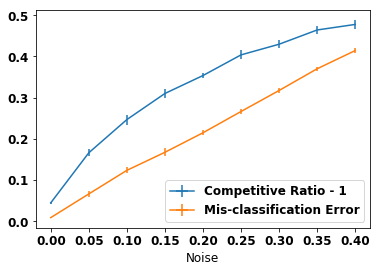

In [9]:
# In[ ]:

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

plt.errorbar(p_mean, CR_mean, yerr = CR_err, xerr=p_err, label = "Competitive Ratio - 1") 
plt.errorbar(p_mean, eps_mean, yerr = eps_err, xerr=p_err, label = "Classification Error") 

plt.xlabel('Noise')
plt.legend()


In [10]:
np.savez('corrupt', crm=CR_mean, em=eps_mean, crerr=CR_err, eps_err=eps_err, p_mean=p_mean, p_err=p_err)